Datatype of first element central_axial: <class 'int'>
edge_image_abs Min: 0, Max: 1130
Datatype of first element edge_image_abs: <class 'int'>


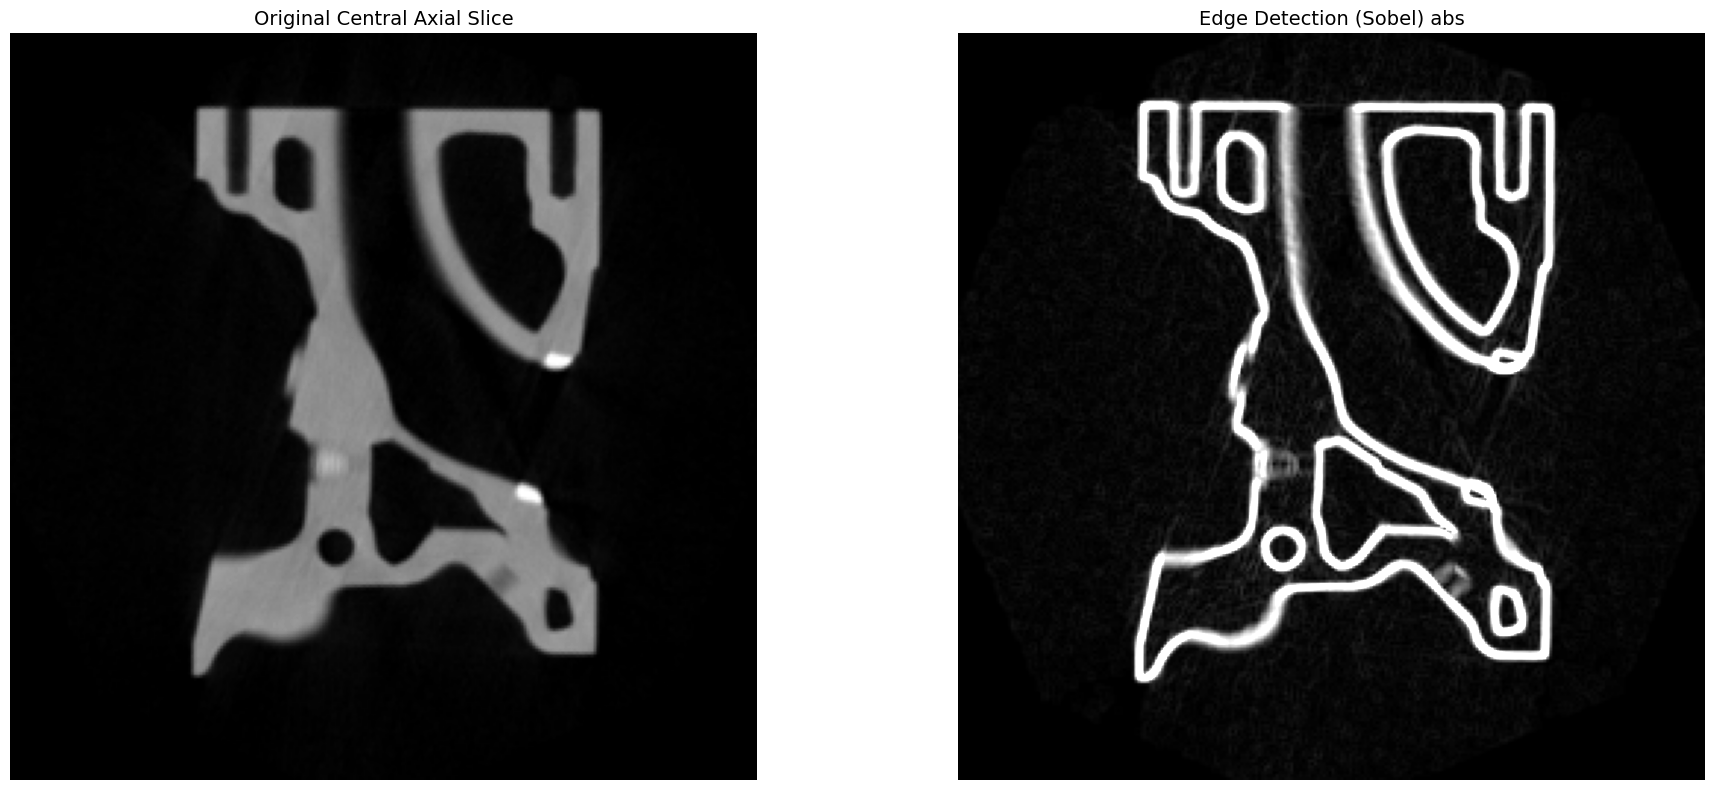

In [160]:
# Not using numpy, beacuse it convert unit8 to float while summing up.

import matplotlib.pyplot as plt

# Function to calculate min and max in a 2D list
def min_max(image):
    flat_list = [pixel for row in image for pixel in row]
    return min(flat_list), max(flat_list)


# Define dimensions
width, height, depth = 256, 256, 128

# Read the binary file and convert it to a list of integers
with open("engine_256x256x128_uint8.raw", "rb") as f:
    raw_data = list(f.read())

# Reshape the raw data into a 3D list of dimensions (depth, height, width)
image_volume = []

for d in range(depth):
    slice_2d = []  # This will store a 2D slice of size (height, width)
    for h in range(height):
        row = []  # This will store a single row of width elements
        for w in range(width):
            # Calculate the 1D index in the raw_data corresponding to (d, h, w)
            index = d * (height * width) + h * width + w
            row.append(raw_data[index])
        slice_2d.append(row)  # Add the row to the current 2D slice
    image_volume.append(slice_2d)  # Add the 2D slice to the 3D volume

# Get the central axial slice
central_axial = image_volume[depth // 2]

# Sobel kernels for X and Y direction
sobel_x_kernel = [[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]
sobel_y_kernel = [[-1, -2, -1], [0, 0, 0], [1, 2, 1]]

# Convolution function (no padding)
def convolve(image, kernel):
    image_height = len(image)
    image_width = len(image[0])
    kernel_height = len(kernel)
    kernel_width = len(kernel)
    
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1
    output = [[0 for _ in range(output_width)] for _ in range(output_height)]
    
    for i in range(output_height):
        for j in range(output_width):
            sum_value = 0
            for ki in range(kernel_height):
                for kj in range(kernel_width):
                    sum_value += image[i + ki][j + kj] * kernel[ki][kj]
            output[i][j] = sum_value
    return output

# Apply convolution with Sobel kernels
sobel_x = convolve(central_axial, sobel_x_kernel)
sobel_y = convolve(central_axial, sobel_y_kernel)

# Calculate gradient magnitude using absolute values
# Initialize an empty list to store the final edge image
edge_image_abs = []

# Loop through each row of the Sobel X and Sobel Y images
for i in range(len(sobel_x)):  # i represents the row index
    # Initialize an empty list to store the edge values for the current row
    row = []
    
    # Loop through each column of the current row
    for j in range(len(sobel_x[0])):  # j represents the column index
        # Calculate the absolute value of the current pixel in Sobel X and Sobel Y
        sobel_x_val = abs(sobel_x[i][j])
        sobel_y_val = abs(sobel_y[i][j])
        
        # Add the absolute values from both Sobel X and Sobel Y
        edge_value = sobel_x_val + sobel_y_val
        
        # Append the edge value to the current row
        row.append(edge_value)
    
    # Append the current row to the final edge image
    edge_image_abs.append(row)


# Plotting
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

print(f"Datatype of first element central_axial: {type(central_axial[0][0])}")


axes[0].imshow(central_axial, cmap="gray")
axes[0].set_title("Original Central Axial Slice", fontsize=14)

# Get the min_max
edge_min, edge_max = min_max(edge_image_abs)
print(f"edge_image_abs Min: {edge_min}, Max: {edge_max}")

print(f"Datatype of first element edge_image_abs: {type(edge_image_abs[0][0])}")

axes[1].imshow(edge_image_abs, cmap="gray", vmin=0, vmax=255)
axes[1].set_title("Edge Detection (Sobel) abs", fontsize=14)

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()


Min: sobel_x -830.0 Max: 499.0
Min: sobel_y -774.0 Max: 720.0
edge_image_abs Min: 0.0 Max: 1130.0


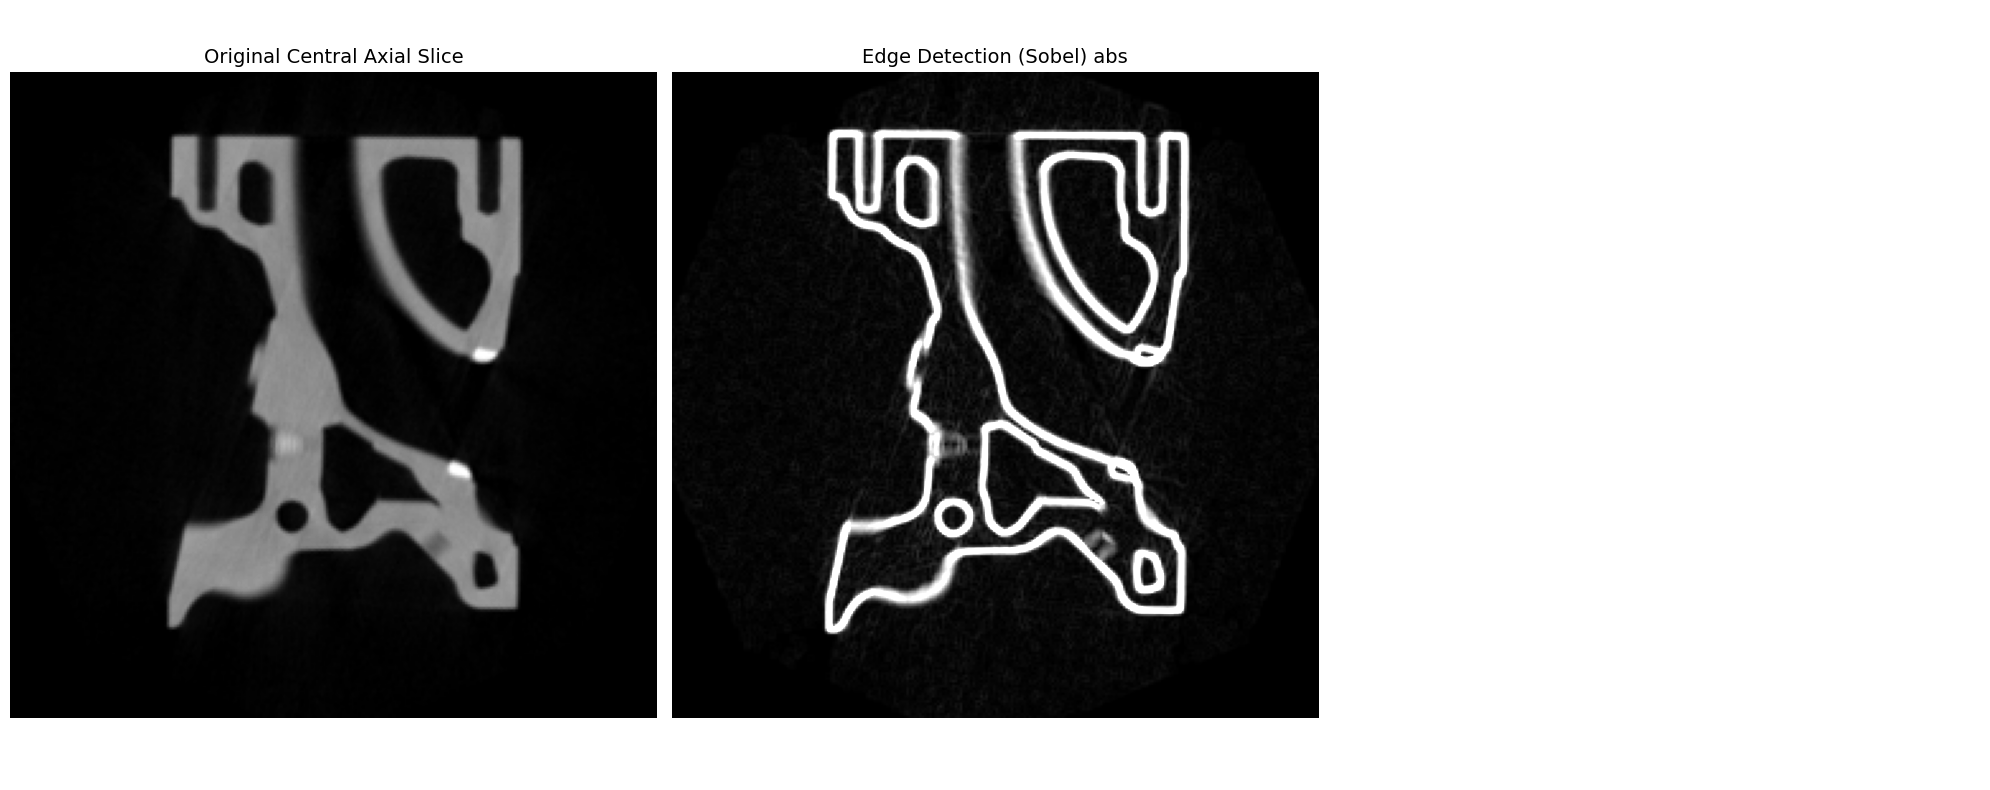

In [4]:
# Using Sobel Operator.
# Here I am not padding, and the convolution only occurs on the valid regions.
# So the size of the image decreases

import numpy as np
import matplotlib.pyplot as plt

width, height, depth = 256, 256, 128 

raw_data = np.fromfile("engine_256x256x128_uint8.raw", dtype=np.uint8)

# https://numpy.org/doc/stable/reference/generated/numpy.ndarray.reshape.html
image_volume = raw_data.reshape((depth, height, width))

# Getting the central axial slice (depth slice)
central_axial = image_volume[depth // 2, :, :]  

# Sobel kernels for X and Y direction
sobel_x_kernel = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y_kernel = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

def convolve(image, kernel):
    # Get dimensions of the image and the kernel
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # Prepare an empty output image with 'valid' size 
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1
    
    output = np.zeros((output_height, output_width))

    # Iterate over every pixel of the original image (valid region)
    for i in range(output_height):
        for j in range(output_width):
            region = image[i:i + kernel_height, j:j + kernel_width]
            
            # Perform element-wise multiplication and sum the result
            output[i, j] = np.sum(region * kernel)
    
    return output

sobel_x = convolve(central_axial, sobel_x_kernel)

# numpy converts the unit to float while using np.sum(region * kernel)
print("Min: sobel_x", sobel_x.min(), "Max:", sobel_x.max())

sobel_y = convolve(central_axial, sobel_y_kernel)

print("Min: sobel_y", sobel_y.min(), "Max:", sobel_y.max())

# Calculate gradient magnitude using absolute values
edge_image_abs = np.abs(sobel_x) + np.abs(sobel_y)

print("edge_image_abs Min:", edge_image_abs.min(), "Max:", edge_image_abs.max())

# Hypothetical gradient magnitude
# edge_image_hypo = np.hypot(sobel_x, sobel_y)

# Plotting remains the same
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

axes[0].imshow(central_axial, cmap="gray")
axes[0].set_title("Original Central Axial Slice", fontsize=14)

# print("1 edge_image_abs.dtype ", edge_image_abs.dtype)  # Check if it's float or int

# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
axes[1].imshow(edge_image_abs, cmap="gray", vmin=0, vmax=255)
axes[1].set_title("Edge Detection (Sobel) abs", fontsize=14)

# axes[2].imshow(edge_image_hypo, cmap="gray")
# axes[2].set_title("Edge Detection (Sobel) hypo", fontsize=14)

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()

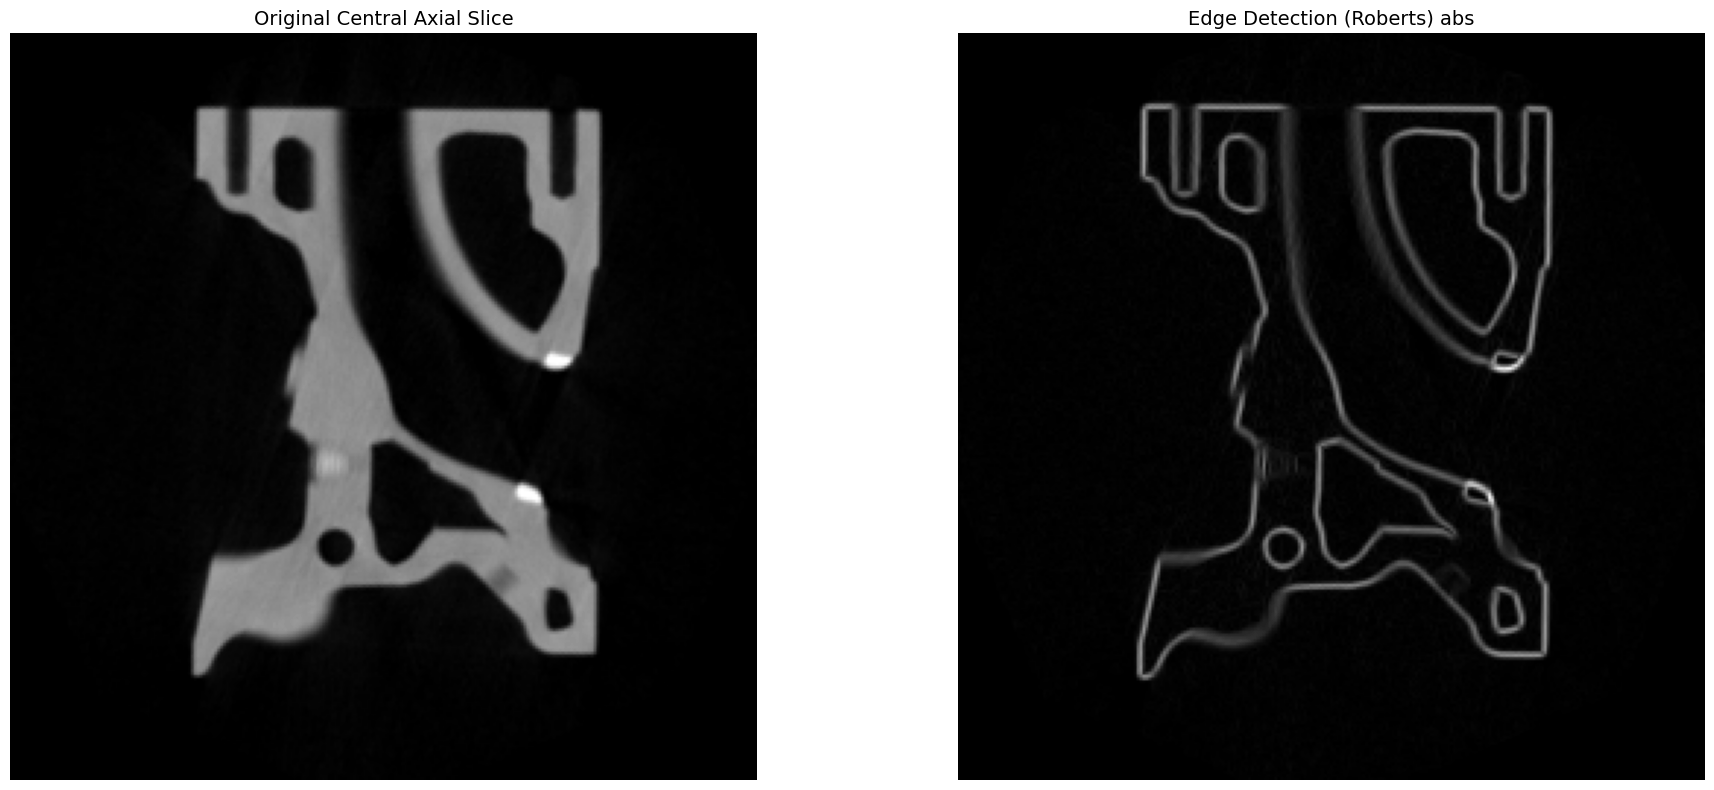

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Roberts Cross Operator

width, height, depth = 256, 256, 128 

raw_data = np.fromfile("engine_256x256x128_uint8.raw", dtype=np.uint8)

# Reshape the raw data into a 3D image volume
image_volume = raw_data.reshape((depth, height, width))

# Get the central axial slice (depth slice)
central_axial = image_volume[depth // 2, :, :]  

# Roberts Cross Operator kernels for X and Y direction (2x2)
roberts_x_kernel = np.array([[1, 0], [0, -1]])
roberts_y_kernel = np.array([[0, 1], [-1, 0]])

def convolve(image, kernel):
    # Get dimensions of the image and the kernel
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # Prepare an empty output image with 'valid' size 
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1
    
    output = np.zeros((output_height, output_width))

    # Iterate over every pixel of the original image (valid region)
    for i in range(output_height):
        for j in range(output_width):
            region = image[i:i + kernel_height, j:j + kernel_width]
            
            # Perform element-wise multiplication and sum the result
            output[i, j] = np.sum(region * kernel)
    
    return output

# Apply convolution with the Roberts kernels
roberts_x = convolve(central_axial, roberts_x_kernel)
roberts_y = convolve(central_axial, roberts_y_kernel)

# print("roberts_x Min:", roberts_x.min(), "Max:", roberts_x.max())
# print("roberts_y Min:", roberts_y.min(), "Max:", roberts_y.max())


# Calculate gradient magnitude using absolute values
edge_image_abs = np.abs(roberts_x) + np.abs(roberts_y)

# print("edge_image_abs Min:", edge_image_abs.min(), "Max:", edge_image_abs.max())

# Plotting the original slice and the edge-detected image
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].imshow(central_axial, cmap="gray")
axes[0].set_title("Original Central Axial Slice", fontsize=14)

axes[1].imshow(edge_image_abs, cmap="gray", vmin=0, vmax=255)
axes[1].set_title("Edge Detection (Roberts) abs", fontsize=14)

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()


Min: sobel_x -607.0 Max: 373.0
Min: sobel_y -584.0 Max: 536.0
edge_image_abs Min: 0.0 Max: 805.0


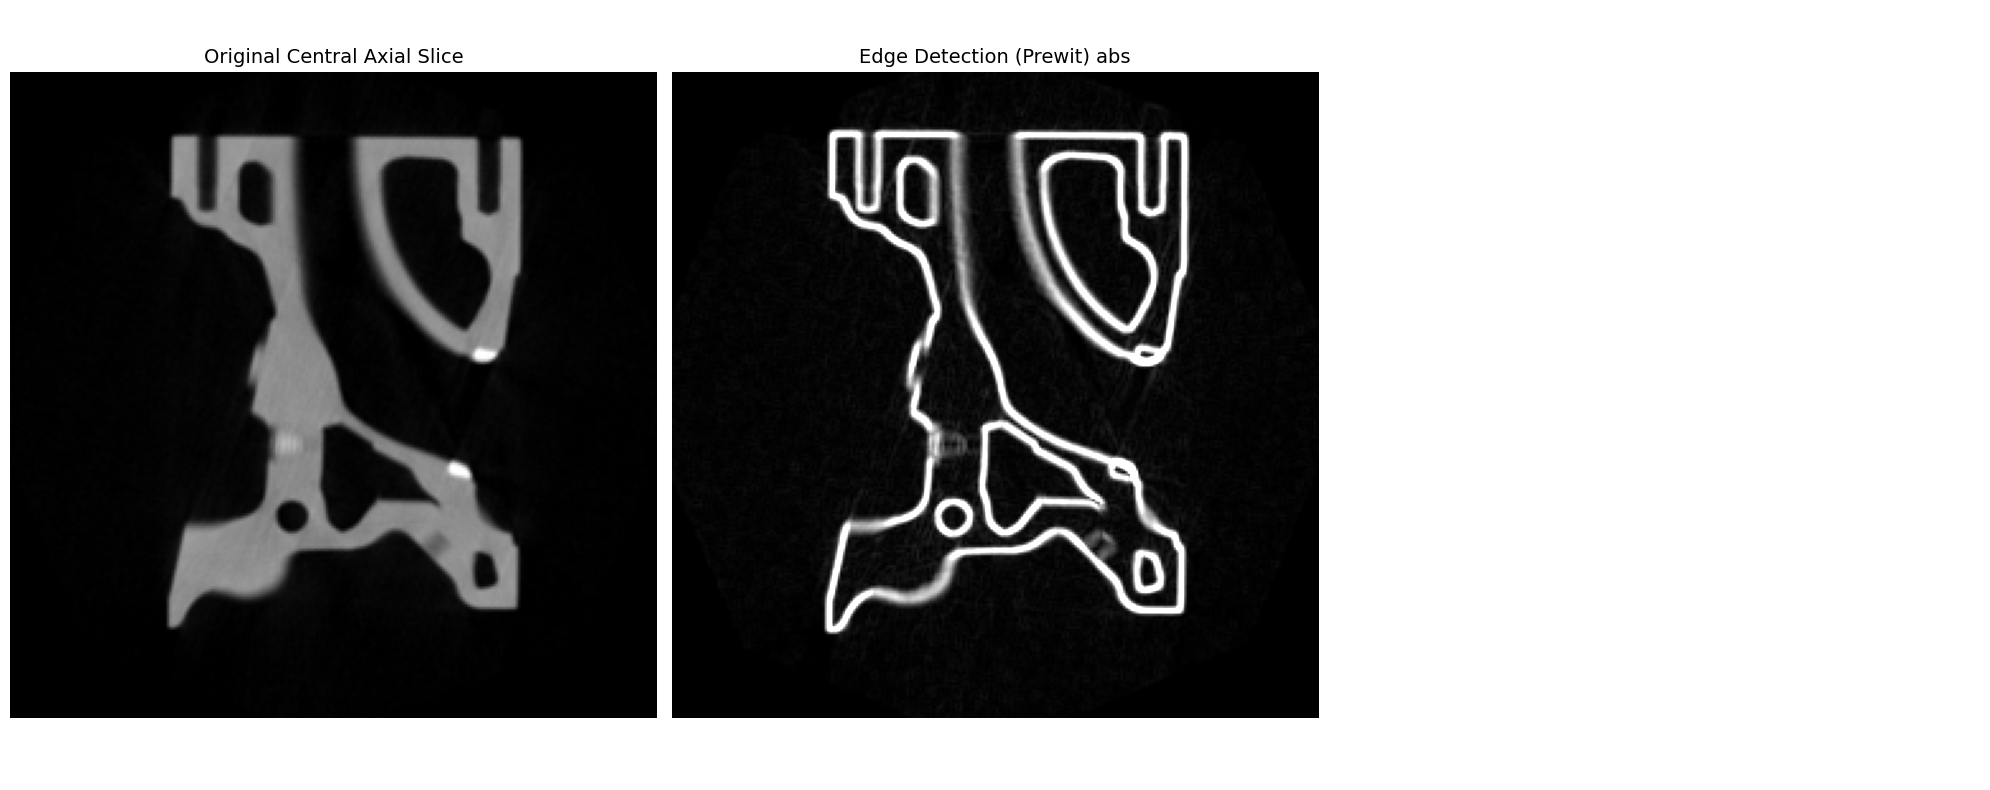

In [12]:
# Using Prewit Operator.
# Here I am not padding, and the convolution only occurs on the valid regions.
# So the size of the image decreases

import numpy as np
import matplotlib.pyplot as plt

width, height, depth = 256, 256, 128 

raw_data = np.fromfile("engine_256x256x128_uint8.raw", dtype=np.uint8)

# https://numpy.org/doc/stable/reference/generated/numpy.ndarray.reshape.html
image_volume = raw_data.reshape((depth, height, width))

# Getting the central axial slice (depth slice)
central_axial = image_volume[depth // 2, :, :]  

# Sobel kernels for X and Y direction
sobel_x_kernel = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
sobel_y_kernel = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])

def convolve(image, kernel):
    # Get dimensions of the image and the kernel
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    
    # Prepare an empty output image with 'valid' size 
    output_height = image_height - kernel_height + 1
    output_width = image_width - kernel_width + 1
    
    output = np.zeros((output_height, output_width))

    # Iterate over every pixel of the original image (valid region)
    for i in range(output_height):
        for j in range(output_width):
            region = image[i:i + kernel_height, j:j + kernel_width]
            
            # Perform element-wise multiplication and sum the result
            output[i, j] = np.sum(region * kernel)
    
    return output

sobel_x = convolve(central_axial, sobel_x_kernel)

# numpy converts the unit to float while using np.sum(region * kernel)
print("Min: sobel_x", sobel_x.min(), "Max:", sobel_x.max())

sobel_y = convolve(central_axial, sobel_y_kernel)

print("Min: sobel_y", sobel_y.min(), "Max:", sobel_y.max())

# Calculate gradient magnitude using absolute values
edge_image_abs = np.abs(sobel_x) + np.abs(sobel_y)

print("edge_image_abs Min:", edge_image_abs.min(), "Max:", edge_image_abs.max())

# Hypothetical gradient magnitude
# edge_image_hypo = np.hypot(sobel_x, sobel_y)

# Plotting remains the same
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

axes[0].imshow(central_axial, cmap="gray")
axes[0].set_title("Original Central Axial Slice", fontsize=14)

# print("1 edge_image_abs.dtype ", edge_image_abs.dtype)  # Check if it's float or int

# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html
axes[1].imshow(edge_image_abs, cmap="gray", vmin=0, vmax=255)
axes[1].set_title("Edge Detection (Prewit) abs", fontsize=14)

# axes[2].imshow(edge_image_hypo, cmap="gray")
# axes[2].set_title("Edge Detection (Sobel) hypo", fontsize=14)

for ax in axes:
    ax.axis("off")

plt.tight_layout()
plt.show()